In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:

import numpy as np
import pandas as pd
import lightgbm as lgb

import matplotlib.pyplot as plt
import math
import datetime
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder


In [ ]:
#reference 
#https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/Fraud Credit Dataset/train_identity.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Fraud Credit Dataset/train_transaction.csv')
test_df2 = pd.read_csv('/content/drive/MyDrive/Fraud Credit Dataset/test_transaction.csv')
test_df1 = pd.read_csv('/content/drive/MyDrive/Fraud Credit Dataset/test_identity.csv')

In [ ]:
df = df1.merge(df2,how='right',left_on='TransactionID',right_on='TransactionID')
print(df.shape)
del df1,df2
test = test_df1.merge(test_df2,how='right',left_on='TransactionID',right_on='TransactionID')
print(test.shape)
del test_df1,test_df2
df = pd.concat([df, test],ignore_index=True)
del test
print(df.shape)

(590540, 434)
(506691, 433)
(1097231, 472)


In [ ]:
#reduce mem
df,NAList = reduce_mem_usage(df)

Memory usage of properties dataframe is : 3951.2103881835938  MB
******************************
Column:  TransactionID
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  id_01
dtype before:  float64
dtype after:  int8
******************************
******************************
Column:  id_02
dtype before:  float64
dtype after:  uint32
******************************
******************************
Column:  id_03
dtype before:  float64
dtype after:  int8
******************************
******************************
Column:  id_04
dtype before:  float64
dtype after:  int8
******************************
******************************
Column:  id_05
dtype before:  float64
dtype after:  int8
******************************
******************************
Column:  id_06
dtype before:  float64
dtype after:  int8
******************************
******************************
Column:  id_07
dtype before:  float64
dtype after:  int8
****

In [ ]:
#Feature Extraction
#combine address and card information to uniquely identify individual
df['uid1'] = df['card1'].astype(str)+','+df['card2'].astype(str)
df['uid2'] = df['card1'].astype(str)+','+df['card2'].astype(str)+','+df['card3'].astype(str)+','+df['card5'].astype(str)
df['uid3'] = df['uid2'].astype(str)+','+df['addr1'].astype(str)+','+df['addr2'].astype(str)
df['uid4'] = df['card3'].astype(str)+','+df['card5'].astype(str)

In [ ]:
df['card1'].value_counts()

7919     28015
9500     26243
15885    22691
17188    19606
15066    14606
         ...  
14750        1
12703        1
17809        1
3480         1
12204        1
Name: card1, Length: 17091, dtype: int64

In [ ]:
df['card2'].value_counts()

321    91731
111    82537
555    80404
490    70496
583    41503
       ...  
121      126
419      126
293      126
552      125
487      123
Name: card2, Length: 502, dtype: int64

In [ ]:
df['card3'].value_counts()

150    956845
185    109960
99       4567
106      3543
117      2841
        ...  
172         1
170         1
154         1
139         1
232         1
Name: card3, Length: 134, dtype: int64

In [ ]:
df['card4'].value_counts()

visa                719649
mastercard          347386
american express     16009
discover              9524
Name: card4, dtype: int64

In [ ]:
df['card5'].value_counts()

226    553537
224    153109
166    102930
102     49491
117     47061
        ...  
115         1
218         1
221         1
175         1
154         1
Name: card5, Length: 139, dtype: int64

In [ ]:
df['uid1'].value_counts()

7919,194     27913
9500,321     26121
15885,545    22580
17188,321    19499
15066,170    14542
             ...  
17694,555        1
6120,555         1
1136,555         1
5176,555         1
5325,555         1
Name: uid1, Length: 18783, dtype: int64

In [ ]:
df['uid2'].value_counts()

9500,321,150,226     26121
15885,545,185,138    22580
7919,194,150,166     21866
17188,321,150,226    19499
15066,170,150,102    14542
                     ...  
13654,99,99,99           1
4611,480,150,117         1
2406,399,150,223         1
11432,555,150,224        1
1051,399,150,223         1
Name: uid2, Length: 19210, dtype: int64

In [ ]:
df['uid3'].value_counts()

15885,545,185,138,99,9      21360
17188,321,150,226,299,87    11340
12695,490,150,226,325,87    10276
9500,321,150,226,204,87      8779
3154,408,185,224,99,9        8758
                            ...  
8886,555,150,226,191,87         1
8139,327,150,223,337,87         1
7675,555,150,226,299,87         1
5362,399,150,236,204,87         1
2569,174,150,166,269,87         1
Name: uid3, Length: 60333, dtype: int64

In [ ]:
df['uid4'].value_counts()

150,226    531549
150,224    112043
150,166    101292
150,117     47059
150,102     44082
            ...  
172,147         1
200,195         1
210,228         1
168,147         1
209,226         1
Name: uid4, Length: 821, dtype: int64

In [ ]:
#we can see there are multilplle entries with same card 1-5 and uid1-4 values
#so lets group by card and uid and take mean of transaction amount
# card 1-3 + card 5 mean + uid1-4mean = 8 new columns
iter_cols = ['card','uid']
for i in range(1,6):
  if(i==4):
    continue
  temp = df.groupby(['card'+str(i)])['TransactionAmt'].agg(['mean'])
  temp = temp.reset_index().rename(columns={'mean': 'card'+str(i)+ '_mean'})

  temp.index = list(temp['card'+str(i)])
  dict_temp = temp.to_dict()['card'+str(i)+ '_mean']
  df['card'+str(i)+ '_mean'] = df['card'+str(i)].map(dict_temp)

for i in range(1,5):
  temp = df.groupby(['uid'+str(i)])['TransactionAmt'].agg(['mean'])
  temp = temp.reset_index().rename(columns={'mean': 'uid'+str(i)+ '_mean'})

  temp.index = list(temp['uid'+str(i)])
  dict_temp = temp.to_dict()['uid'+str(i)+ '_mean']
  df['uid'+str(i)+ '_mean'] = df['uid'+str(i)].map(dict_temp)
  



In [ ]:
# print(df['P_emaildomain'].value_counts())
#searched all email domains and some email domain repeat eg msn and outlook, yahoo.com, yahoo.fr
#and extension different, .com,.net,.fr,.uk,etc....
#split email domain into domain name and extension
#since we are intrested in outliers, not combining remaining to other bucket
#added 1 new column
P_domainName = []
print(df['P_emaildomain'].values)
for email in df['P_emaildomain'].values:
  if(email!=email):
    name = 'N/A'
    P_domainName.append(name)
    continue
  name = email.split('.')[0]
  if(name=='hotmail' or name=='outlook' or name=='msn' or name=='live'):
    name='microsoft'
  elif(name=='icloud' or name=='mac' or name=='me'):
    name='apple'
  elif(name=='aim'):
    name='aol'
  elif(name=='twc' or name=='charter'):
    name='twc'
  elif(name=='q' or name=='embarqmail'):
    name='centurylink'
  P_domainName.append(name)

P_domainName = pd.Series(P_domainName)
df['P_domainName'] = P_domainName
print(df['P_domainName'].value_counts())
  


[nan 'gmail.com' 'outlook.com' ... 'hotmail.com' 'hotmail.com'
 'hotmail.com']
gmail           436796
yahoo           186568
N/A             163648
microsoft       112987
anonymous        71062
aol              52805
apple            15891
comcast          14474
att               7647
sbcglobal         5767
verizon           5011
ymail             4075
bellsouth         3437
cox               2657
optonline         1937
twc               1882
centurylink       1212
mail              1156
rocketmail        1105
earthlink          979
netzero            706
frontier           594
roadrunner         583
juno               574
windstream         552
web                518
frontiernet        397
suddenlink         323
cfl                318
cableone           311
prodigy            303
gmx                298
sc                 277
protonmail         159
ptd                140
servicios-ta        80
scranton             2
Name: P_domainName, dtype: int64


In [ ]:
#added 1 new column
R_domainName = []
for email in df['R_emaildomain'].values:
  if(email!=email):
    name = 'N/A'
    R_domainName.append(name)
    continue
  name = email.split('.')[0]
  if(name=='hotmail' or name=='outlook' or name=='msn' or name=='live'):
    name='microsoft'
  elif(name=='icloud' or name=='mac' or name=='me'):
    name='apple'
  elif(name=='aim'):
    name='aol'
  elif(name=='twc' or name=='charter'):
    name='twc'
  elif(name=='q' or name=='embarqmail'):
    name='centurylink'
  R_domainName.append(name)

R_domainName = pd.Series(R_domainName)
df['R_domainName'] = R_domainName
print(df['R_domainName'].value_counts())
  


N/A             824070
gmail           119081
microsoft        65450
anonymous        39644
yahoo            24912
aol               7316
apple             4345
comcast           3513
verizon           1202
sbcglobal         1163
att                870
cox                854
bellsouth          795
web                514
ymail              405
optonline          350
mail               341
twc                324
prodigy            303
gmx                297
centurylink        213
earthlink          170
rocketmail         126
juno               111
frontier           110
windstream         104
roadrunner         101
servicios-ta        80
protonmail          75
ptd                 70
scranton            69
cfl                 57
suddenlink          55
cableone            46
netzero             43
frontiernet         38
sc                  14
Name: R_domainName, dtype: int64


In [ ]:
#add extension of P and R emailDomain 
# + 2 columns
R_ext = []
for email in df['R_emaildomain'].values:
  if(email!=email):
    name = 'N/A'
    R_ext.append(name)
    continue
  name = email.split('.')[-1]
  
  R_ext.append(name)

R_ext = pd.Series(R_ext)
df['R_ext'] = R_ext
print(df['R_ext'].value_counts())
  


P_ext = []
for email in df['P_emaildomain'].values:
  if(email!=email):
    name = 'N/A'
    P_ext.append(name)
    continue
  name = email.split('.')[-1]
  
  P_ext.append(name)

P_ext = pd.Series(P_ext)
df['P_ext'] = P_ext
print(df['P_ext'].value_counts())


N/A      824070
com      254604
net        9540
mx         4510
es         1572
fr         1087
de         1080
uk          399
gmail       196
jp          104
edu          69
Name: R_ext, dtype: int64
com      877701
N/A      163648
net       45780
mx         4600
es         1762
fr         1124
de         1083
gmail       993
uk          437
jp          101
edu           2
Name: P_ext, dtype: int64


In [ ]:
#transactionDT - seconds, 1st entry = 24*60*60 , try to make new columns -  time_of_day,day_of_year,day_of_week,month,week number in year
#transactionDT spans 6 months
#+1 column
print(df['TransactionDT'].isnull().values.any())
#no nan
lis_of_times = []
cur_time = 0 #12 pm
for i in range(len(df['TransactionDT'])):
    diff = df['TransactionDT'][i] - df['TransactionDT'][0]
    lis_of_times.append((cur_time + diff//(60*60))%24)
print(len(lis_of_times))
df['hour'] = pd.Series(lis_of_times)
print(df['hour'].value_counts())

False
1097231
19    77870
20    77265
21    77139
18    76926
17    75927
22    75848
23    73604
16    72652
0     68404
15    64434
1     59223
14    54258
2     48943
13    39799
3     38082
4     27136
12    24284
5     17721
11    13357
6     10851
10     7161
7      6669
8      4845
9      4833
Name: hour, dtype: int64


In [ ]:
#+3 columns
start_date = datetime.datetime.strptime('2020-01-01', '%Y-%m-%d')
lis_of_months = []
lis_of_day_year=[]
lis_of_week = []
for seconds in df['TransactionDT'].values:
  cur_date = start_date + datetime.timedelta(0,int(seconds) - 86400)
  lis_of_months.append(cur_date.month)
  lis_of_day_year.append(cur_date.timetuple().tm_yday)
  lis_of_week.append(int(cur_date.strftime("%V")))

lis_of_months = pd.Series(lis_of_months)
lis_of_day_year=pd.Series(lis_of_day_year)
lis_of_week = pd.Series(lis_of_week)

df['month'] = lis_of_months
df['day'] = lis_of_day_year
df['week'] = lis_of_week

print(df['month'].value_counts())
print(df['day'].value_counts())
print(df['week'].value_counts())

1     250389
4      97625
3      96196
5      87551
2      86417
12     86134
6      85430
8      79544
11     77477
10     74488
9      73737
7       2243
Name: month, dtype: int64
23     12656
20     11485
24     11452
22     11274
19     10456
       ...  
269     1878
283     1863
262     1829
297     1828
255     1699
Name: day, Length: 336, dtype: int64
3     69666
4     55363
2     53777
1     43070
14    28021
53    23698
18    23536
10    23523
5     23362
6     23170
15    21888
13    21315
17    21004
23    20967
24    20802
16    20635
11    20534
49    20522
25    20389
12    20353
19    20337
8     20316
7     20292
22    20263
9     19960
36    19617
51    19567
52    18629
20    18613
44    18531
45    18344
21    18239
33    18120
40    18021
46    18014
48    17844
26    17779
47    17615
50    17346
34    17276
35    17215
32    16985
42    16803
38    16667
41    16526
39    16459
37    16094
43    15837
31     8834
27     5493
Name: week, dtype: int64


In [ ]:
#browser, fraud most likely happens on outdated browsers, these have less value counts
#and can't bunch up browsers with lower count as we could lose important info as class imbalance
print(df['id_31'].value_counts())

chrome 63.0              22000
mobile safari 11.0       13423
mobile safari generic    11474
ie 11.0 for desktop       9030
safari generic            8195
                         ...  
cyberfox                     1
Inco/Minion                  1
Nokia/Lumia                  1
chrome 69.0                  1
Samsung/SCH                  1
Name: id_31, Length: 130, dtype: int64


In [ ]:
#we decided to use frequency count,we felt fequency of certain columns will be related to isFraud as
# there is good chance hacker will do it more than once and exploits usually need a lot of variables to 
# have special value, so frequency might be important
# does it make sense??
#added 5+15+9+5+4 columns
for i in range(1,6):
  if(i==4):
    continue
  df['card' + str(i)+'_fenc'] = df['card' + str(i)].map(df['card' + str(i)].value_counts().to_dict())

for i in range(1,15):
  df['C'+str(i)+'_fenc'] = df['C'+str(i)].map(df['C'+str(i)].value_counts().to_dict())

for i in range(1,9):
  df['D'+str(i)+'_fenc'] = df['D'+str(i)].map(df['D'+str(i)].value_counts().to_dict())

for i in range(1,5):
  df['uid'+str(i)+'_fenc'] = df['uid'+str(i)].map(df['uid'+str(i)].value_counts().to_dict())

df['R_domainName'+'_fenc'] = df['R_domainName'].map(df['R_domainName'].value_counts().to_dict())
df['P_domainName'+'_fenc'] = df['P_domainName'].map(df['P_domainName'].value_counts().to_dict())
df['R_ext'+'_fenc'] = df['R_ext'].map(df['R_ext'].value_counts().to_dict())
df['P_ext'+'_fenc'] = df['P_ext'].map(df['P_ext'].value_counts().to_dict())



In [ ]:
#frequency encoding for datetime
#+4 columns
df['hour'+'_fenc'] = df['hour'].map(df['hour'].value_counts().to_dict())
df['month'+'_fenc'] = df['month'].map(df['month'].value_counts().to_dict())
df['day'+'_fenc'] = df['day'].map(df['day'].value_counts().to_dict())
df['week'+'_fenc'] = df['week'].map(df['week'].value_counts().to_dict())



In [ ]:
#useless columns
cols_with_only_nan = []
for col in df.columns:
    if(pd.isnull(df[col]).sum()/df.shape[0]>0.95):#only Nan
        cols_with_only_nan.append(col)
print(cols_with_only_nan)
print(len(cols_with_only_nan))
#should we drop???

['id_23', 'id_27', 'id-23', 'id-27']
4


In [ ]:
for col in df.columns:
  if(df[col].dtype.name=='object'):
    print(col)
print(df['id_12'].value_counts(dropna=False))

id_12
id_15
id_16
id_23
id_27
id_28
id_29
id_30
id_31
id_33
id_34
id_35
id_36
id_37
id_38
DeviceType
DeviceInfo
ProductCD
card4
card6
P_emaildomain
R_emaildomain
M1
M2
M3
M4
M5
M6
M7
M8
M9
id-12
id-15
id-16
id-23
id-27
id-28
id-29
id-30
id-31
id-33
id-34
id-35
id-36
id-37
id-38
uid1
uid2
uid3
uid4
P_domainName
R_domainName
R_ext
P_ext
NaN         952998
NotFound    123025
Found        21208
Name: id_12, dtype: int64


In [ ]:
for col in df.columns:
  if(df[col].dtype.name=='object'):
    #le = OrdinalEncoder() needs 2d and labelencoder does same thing
    le= LabelEncoder()
    temp = (le.fit_transform(df[col].replace(np.nan,"Nan",regex=True)))
    temp = pd.Series(temp)
    df[col]=temp


In [ ]:
#after label encoding
df = df.drop(['TransactionID'],axis=1)
print(df.head())

   id_01  id_02  id_03  id_04  ...  hour_fenc  month_fenc  day_fenc  week_fenc
0   -101      0    -14    -29  ...      68404      250389      8056      43070
1   -101      0    -14    -29  ...      68404      250389      8056      43070
2   -101      0    -14    -29  ...      68404      250389      8056      43070
3   -101      0    -14    -29  ...      68404      250389      8056      43070
4      0  70787    -14    -29  ...      68404      250389      8056      43070

[5 rows x 529 columns]


In [ ]:
Y = df['isFraud'].copy()
X = df.drop(['isFraud'],axis=1)
del df

In [ ]:
X_train = X.iloc[0:590540]
X_test = X.iloc[590540:]
del X
Y_train = Y.iloc[0:590540]
Y_test = Y.iloc[590540:]
del Y
#carefule!!!!!!!!!
Y_train = pd.DataFrame({'isFraud':Y_train})
Y_test = pd.DataFrame({'isFraud':Y_test})
Y_test = Y_test.reset_index()
X_test = X_test.reset_index()
Y_test = Y_test.drop(['index'],axis=1)
X_test = X_test.drop(['index'],axis=1)

#!!!!!!!!!!!!!!!!!!!!!


In [ ]:
#pickle x_test,train,y_test,ytrain
X_train.to_pickle('x_train.pkl')
X_test.to_pickle('x_test.pkl')
Y_test.to_pickle('y_test.pkl')
Y_train.to_pickle('y_train.pkl')

In [ ]:
#use this to save time
# X_train = pd.read_pickle('x_train.pkl')
# Y_train = pd.read_pickle('y_train.pkl')
# X_test = pd.read_pickle('x_test.pkl')
# Y_test = pd.read_pickle('y_test.pkl')

In [ ]:
#reason for parameter
#light bgm docs say , for higher acc keep learning rate very small so 0.006
# since class imbalance we use auc as the metric, we don't specify a max_depth as
#light bgm docs says for high acc,min_Data_in_leaf must in 100's and num_leaves must be high
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import gc

params = {'num_leaves': 600,
          'min_data_in_leaf': 100,
          'learning_rate': 0.006,
          "boosting_type": "gbdt",
          "metric": 'auc',
          'random_state': 2020,
}

y_preds = ([0]*X_test.shape[0])#for average prediction from 5 folds
score = 0
feature_importances = pd.DataFrame()
#lgb returns feature importance for each fold
kf = KFold(n_splits=5)
iter=0
for train_indx,valid_indx in kf.split(X_train):
  x_train,y_train = X_train[X_train.columns].iloc[train_indx],Y_train.iloc[train_indx]
  x_valid,y_valid = X_train[X_train.columns].iloc[valid_indx],Y_train.iloc[valid_indx]

  dtrain = lgb.Dataset(x_train, label=y_train)
  dvalid = lgb.Dataset(x_valid, label=y_valid)

  clf = lgb.train(params, dtrain, 200, valid_sets = [dtrain, dvalid], verbose_eval=100, early_stopping_rounds=100)

  feature_importances[str(iter+1)] = clf.feature_importance()
  iter+=1
  
  y_pred_valid = clf.predict(x_valid)
    
  score += roc_auc_score(y_valid, y_pred_valid) 
  temp_pred = clf.predict(X_test)
  for i in range(len(y_preds)):
    y_preds[i]+=(temp_pred[i]/5)
    
  del x_train, x_valid, y_train, y_valid,temp_pred
  gc.collect()

print("Mean FOld auc = "+str(score/5))

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.944724	valid_1's auc: 0.882809
[200]	training's auc: 0.955086	valid_1's auc: 0.890316
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.955086	valid_1's auc: 0.890316
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.943788	valid_1's auc: 0.908853
[200]	training's auc: 0.95463	valid_1's auc: 0.915153
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.95463	valid_1's auc: 0.915153
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.945509	valid_1's auc: 0.904002
[200]	training's auc: 0.95615	valid_1's auc: 0.911763
Did not meet early stopping. Best iteration is:
[200]	training's auc: 0.95615	valid_1's auc: 0.911763
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.943044	valid_1's auc: 0.916925
[200]	training's auc: 0.953886	valid_1's auc: 0.924409
Did

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/Fraud Credit Dataset/sample_submission.csv')
submission['isFraud'] = y_preds
submission.to_csv('sub1.csv',index=False)
#submitted on kaggle gives  92.36 acc

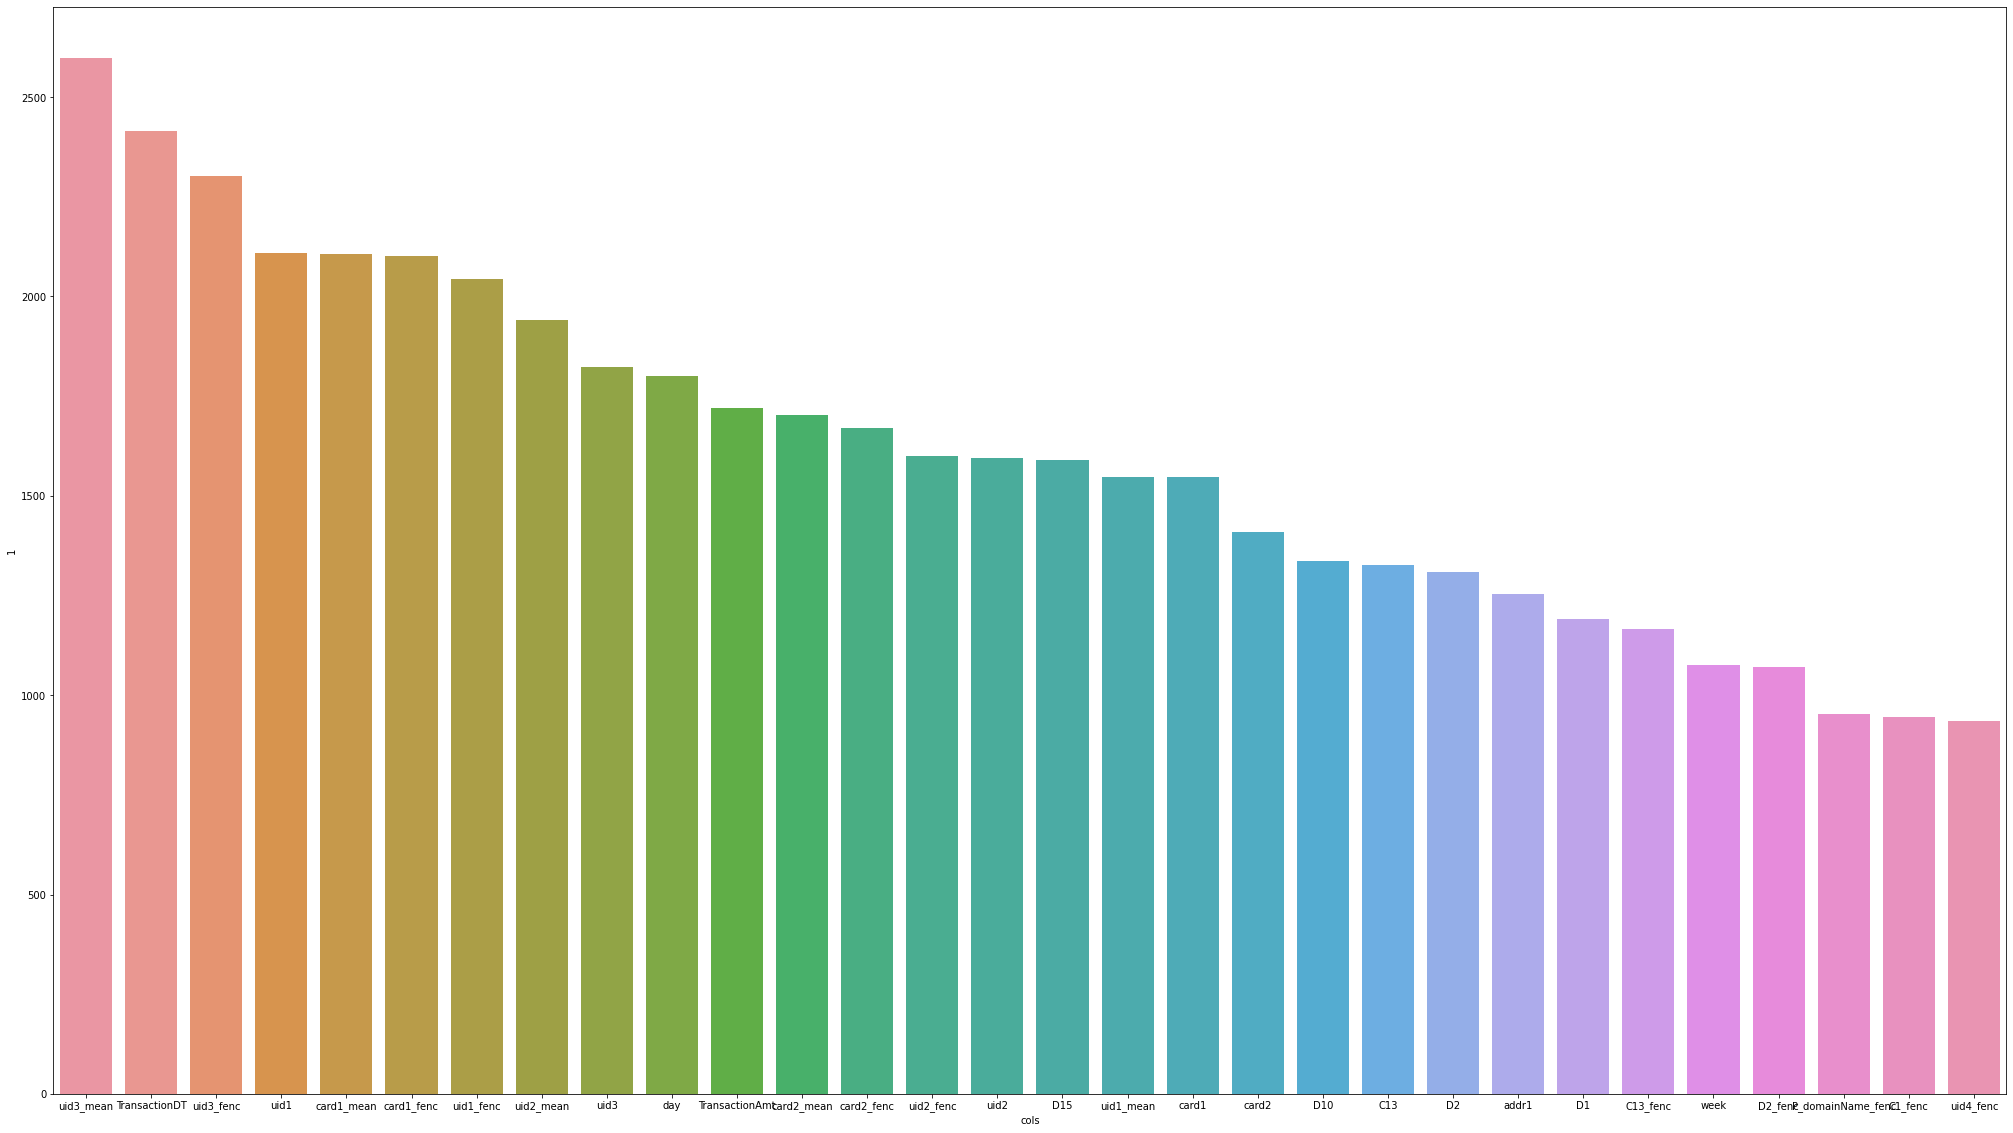

In [ ]:
import seaborn
feature_importances['cols'] = X_train.columns
plt.figure(figsize=(35,20))
temp = feature_importances.sort_values(by='1',ascending=False).iloc[:30]
seaborn.barplot(data=temp,x='cols',y='1')
plt.show()

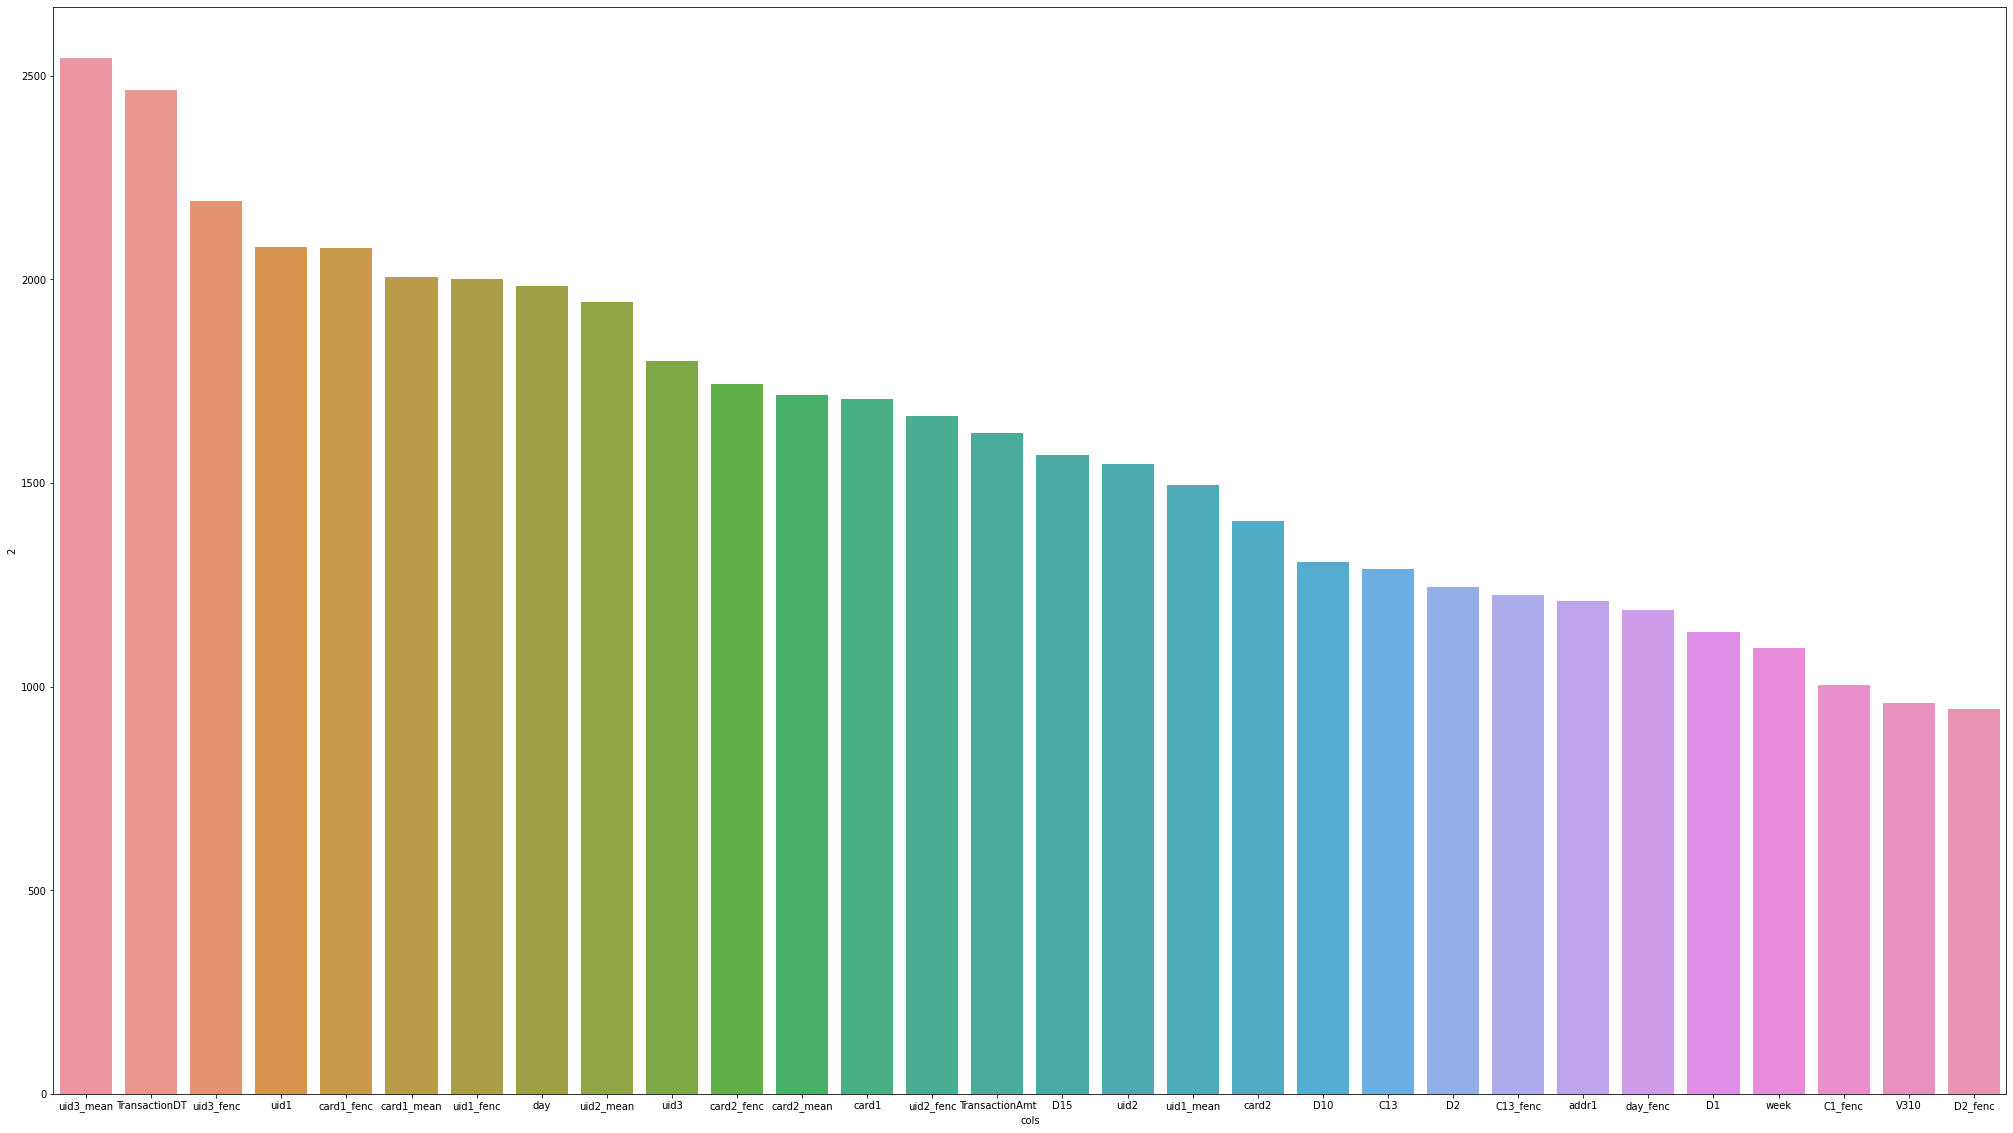

In [ ]:
import seaborn
feature_importances['cols'] = X_train.columns
plt.figure(figsize=(35,20))
temp = feature_importances.sort_values(by='2',ascending=False).iloc[:30]
seaborn.barplot(data=temp,x='cols',y='2')
plt.show()

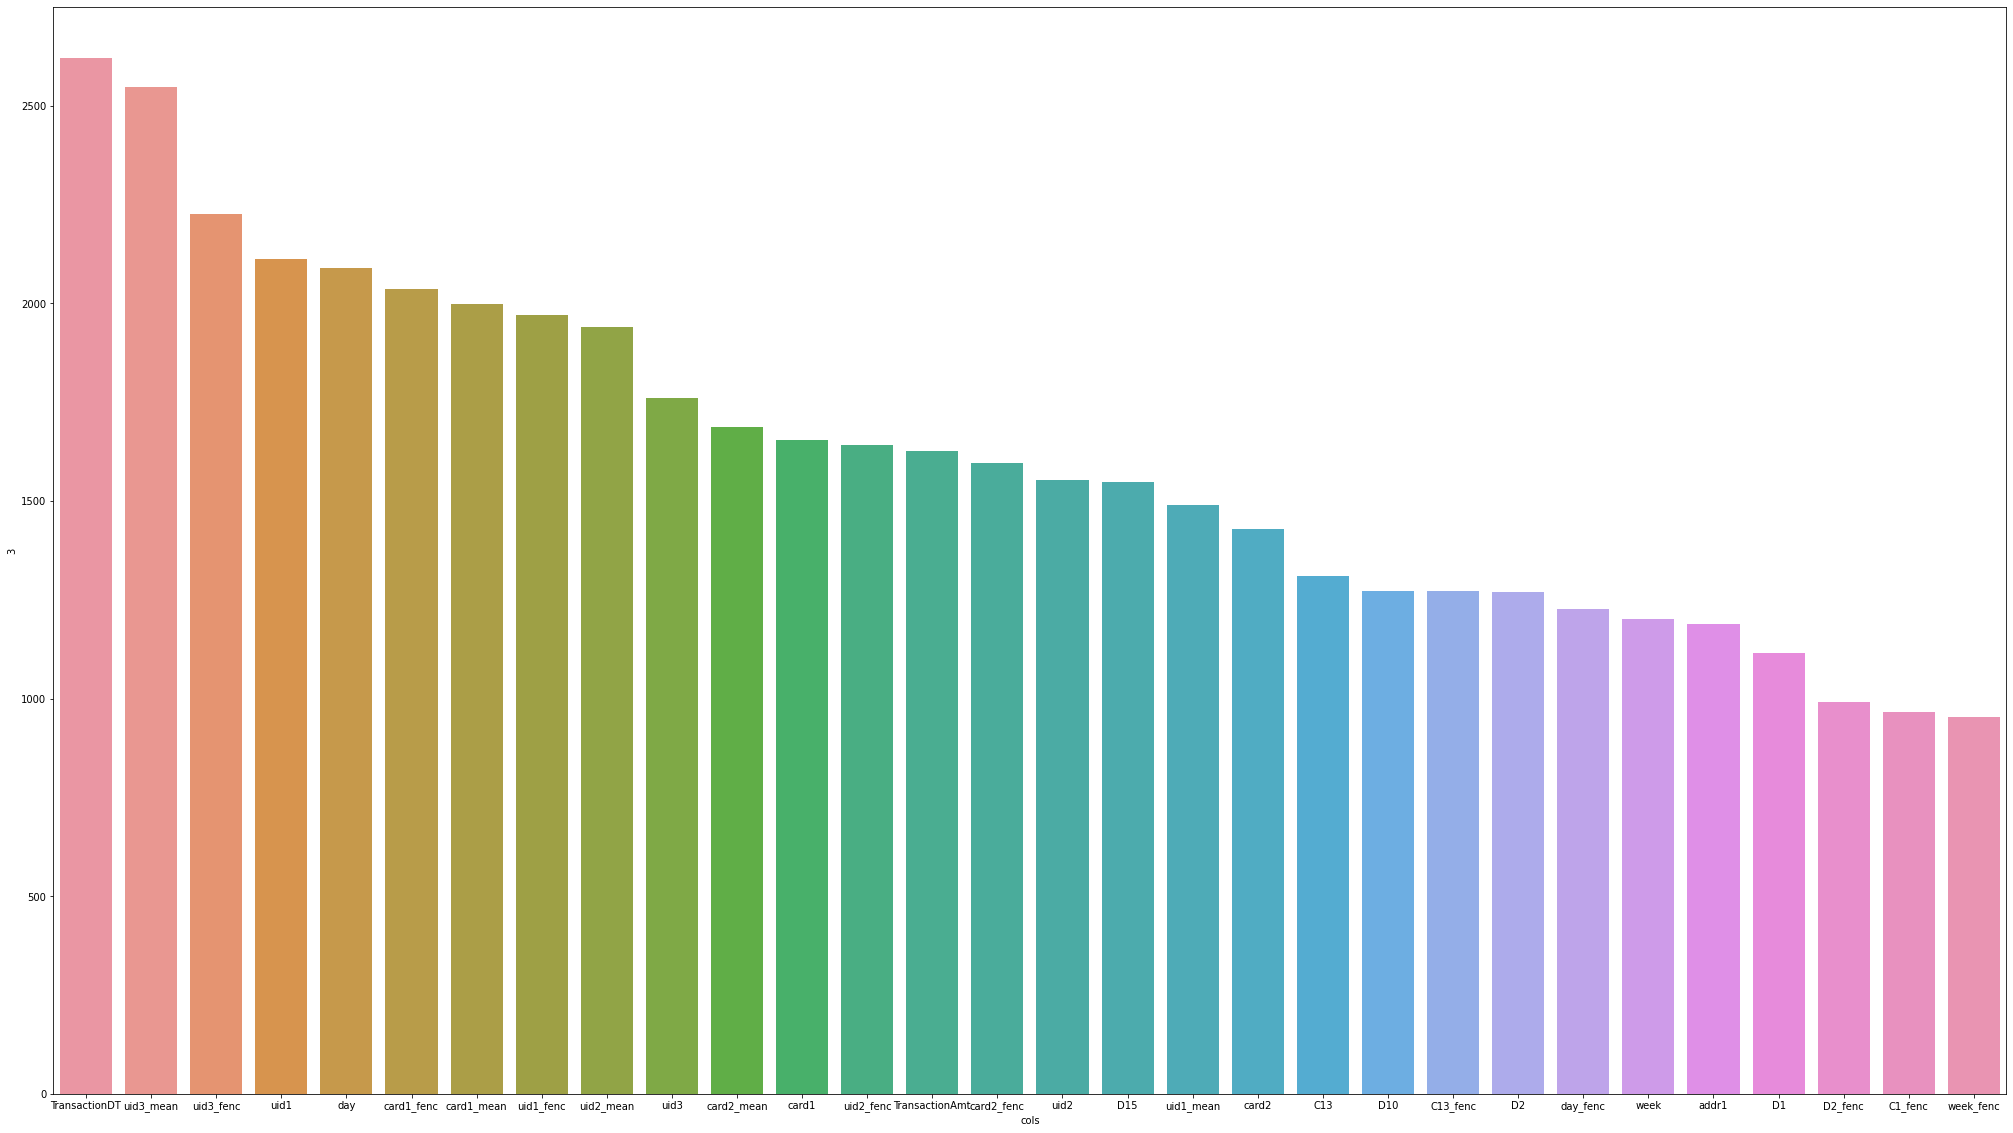

In [ ]:
import seaborn
feature_importances['cols'] = X_train.columns
plt.figure(figsize=(35,20))
temp = feature_importances.sort_values(by='3',ascending=False).iloc[:30]
seaborn.barplot(data=temp,x='cols',y='3')
plt.show()

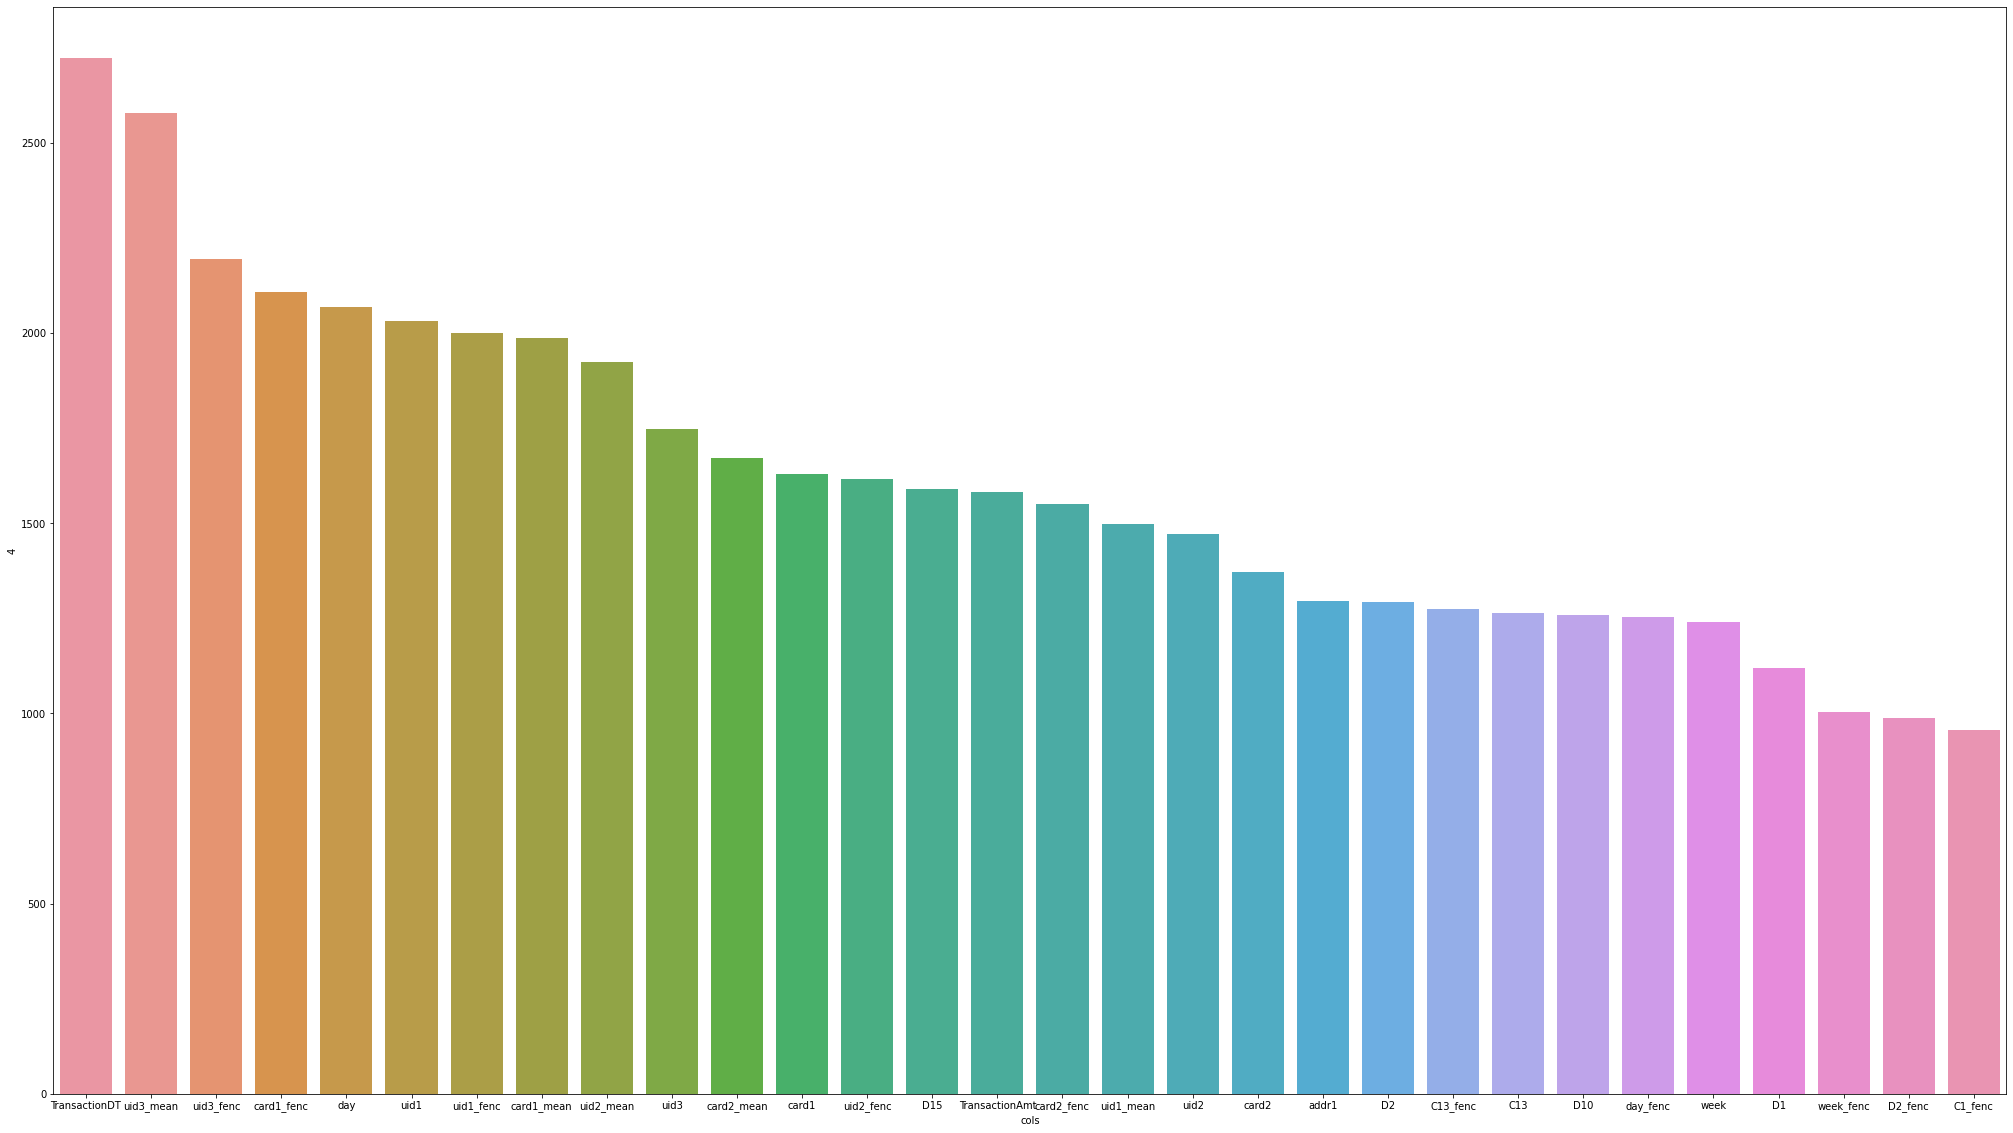

In [ ]:
import seaborn
feature_importances['cols'] = X_train.columns
plt.figure(figsize=(35,20))
temp = feature_importances.sort_values(by='4',ascending=False).iloc[:30]
seaborn.barplot(data=temp,x='cols',y='4')
plt.show()

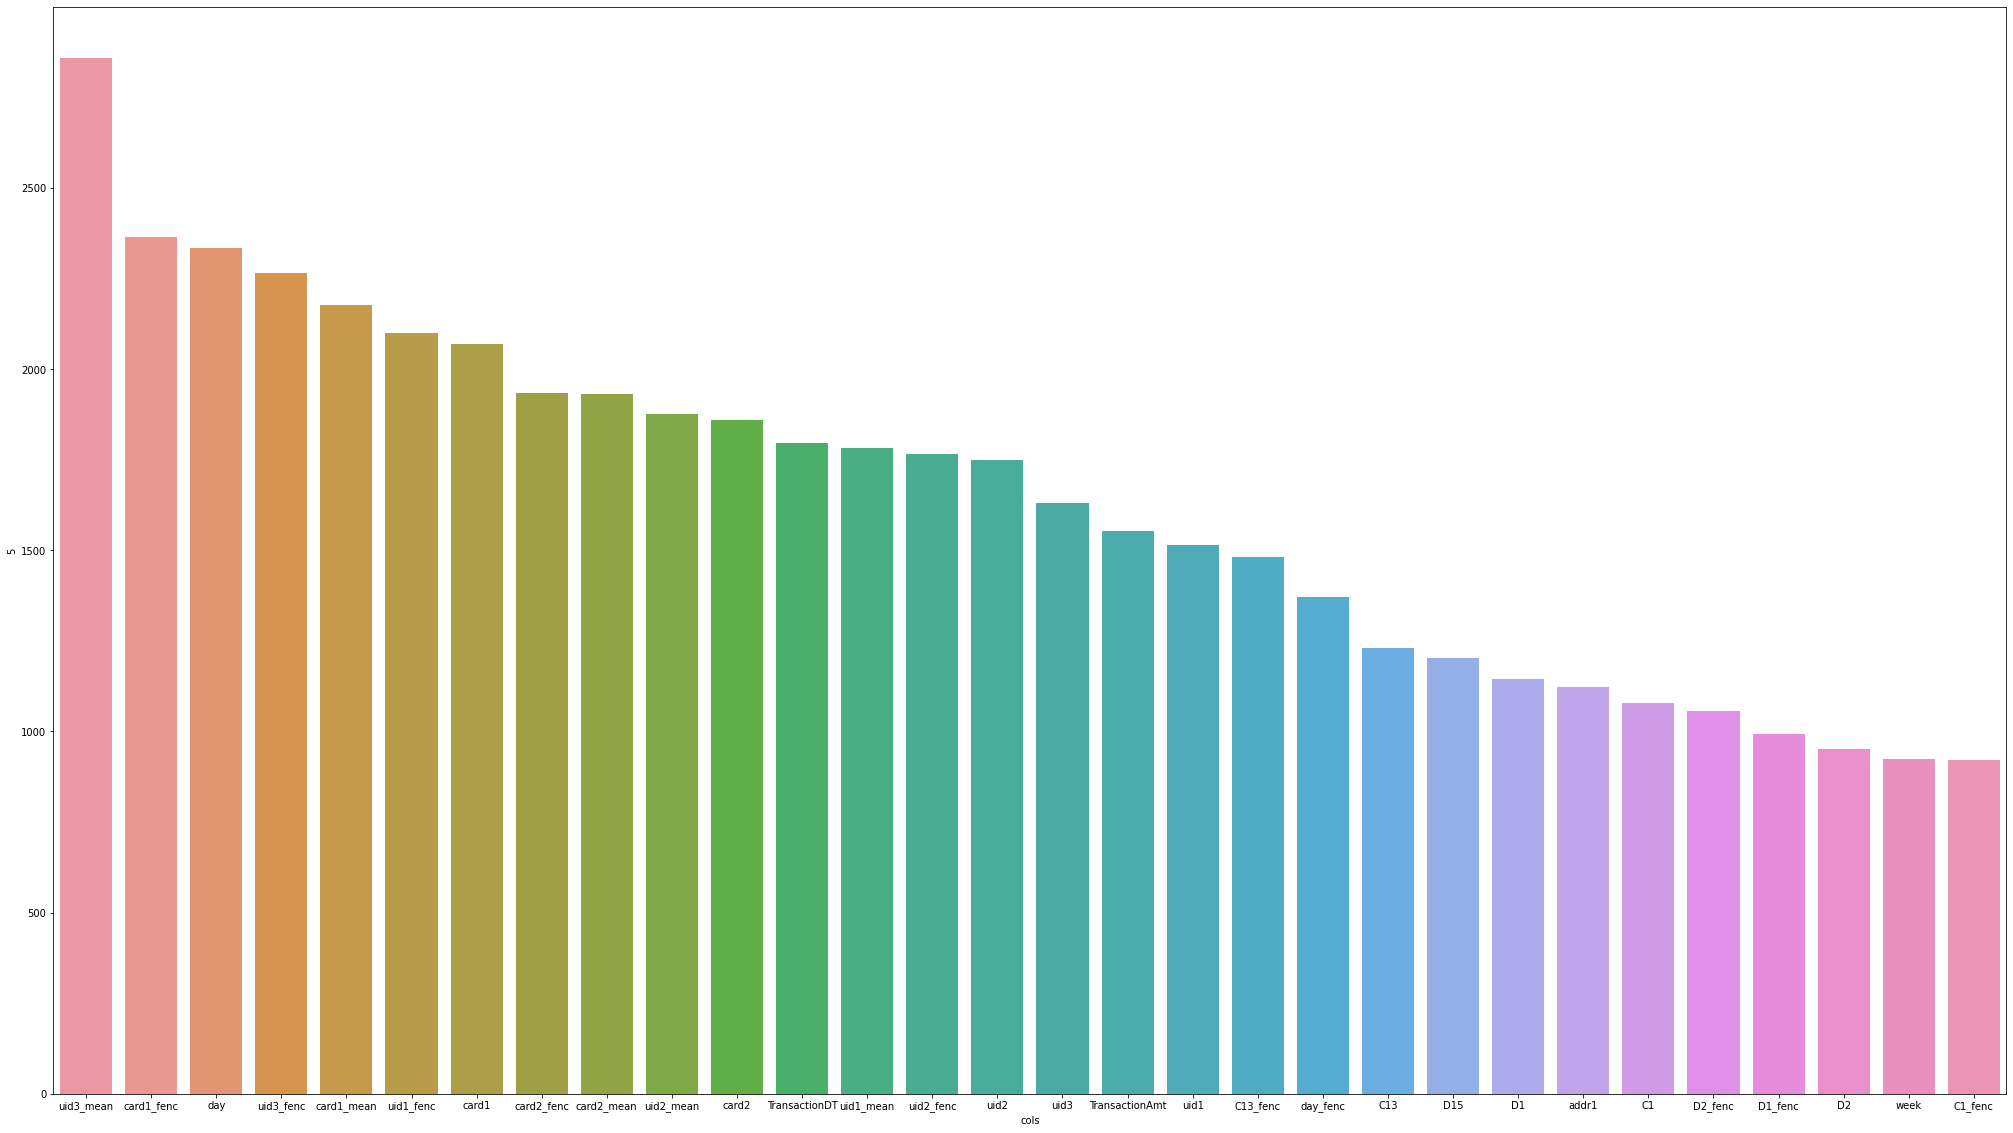

In [ ]:
import seaborn
feature_importances['cols'] = X_train.columns
plt.figure(figsize=(35,20))
temp = feature_importances.sort_values(by='5',ascending=False).iloc[:30]
seaborn.barplot(data=temp,x='cols',y='5')
plt.show()

In [ ]:
feature_importances

,1,2,3,4,5,cols
0,293,282,237,240,224,id_01
1,502,492,574,525,682,id_02
2,85,67,92,64,78,id_03
3,21,29,25,21,38,id_04
4,294,328,358,339,327,id_05
...,...,...,...,...,...,...
523,96,85,108,96,95,P_ext_fenc
524,775,800,821,806,656,hour_fenc
525,577,462,600,634,342,month_fenc
526,889,1188,1226,1253,1371,day_fenc
